In [1]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
best_model = YOLO("runs\\detect\\train2\\weights\\best.pt")

In [3]:
test_path ="test\\3bf2e30c-Bacterial_diseases_-_Aeromoniasis_34.jpg"

In [4]:
result = best_model.predict(source=test_path, show=True, conf=0.3, save=True)


image 1/1 g:\4 th year taf\project eka\models\re-pp1\test\3bf2e30c-Bacterial_diseases_-_Aeromoniasis_34.jpg: 640x640 2 bacterial_reds, 2933.4ms
Speed: 29.3ms preprocess, 2933.4ms inference, 36.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict8


In [5]:
cv2.destroyAllWindows()

## Extract bounding boxes and class information

In [6]:
for detection in result[0].boxes:
    
    bbox = detection.xyxy[0].tolist()  
    x_min, y_min, x_max, y_max = bbox[:4]
       
    confidence = detection.conf[0].item()  
       
    class_id = int(detection.cls[0])

    cls_name = {
        0:"bacterial_gill",
        1:"bacterial_red",
        2:"fungal_saprolegniasis"
    }  
    
    print(f"Bounding Box: {x_min}, {y_min}, {x_max}, {y_max}")
    print(f"Confidence: {confidence}")
    print(f"Class ID: {cls_name.get(class_id)}")

Bounding Box: 1.0146987438201904, 19.672359466552734, 33.92271423339844, 40.04138946533203
Confidence: 0.5146105289459229
Class ID: bacterial_red
Bounding Box: 74.15043640136719, 72.97014617919922, 133.74986267089844, 162.35423278808594
Confidence: 0.43326839804649353
Class ID: bacterial_red


## handle non-max suppression (NMS)

In [7]:
def iou(box1, box2):

    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
   
    overlap_area = max(0, x2 - x1) * max(0, y2 - y1)
   
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = area_box1 + area_box2 - overlap_area
    return overlap_area / union_area if union_area > 0 else 0

In [8]:
def apply_nms(bboxes, scores, iou_threshold=0.5):

    indices = np.argsort(scores)[::-1]  
    keep = []
    
    while len(indices) > 0:
        current = indices[0]
        keep.append(current)
        indices = indices[1:]
        indices = [
            i for i in indices if iou(bboxes[current], bboxes[i]) < iou_threshold
        ]
    
    return keep

In [9]:
def disease_detector(img_path):
    try:
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at path: {img_path}")
        original = image.copy()
    except Exception as e:
        print(f"Error loading image: {e}")
        return

    try:
        result = best_model.predict(source=img_path, show=False, conf=0.3)
    except Exception as e:
        print(f"Error during prediction: {e}")
        return


    detections = result[0].boxes.data.cpu().numpy()
    bboxes = detections[:, :4]
    scores = detections[:, 4]
    class_ids = detections[:, 5]
    

    nms_indices = apply_nms(bboxes, scores, iou_threshold=0.1)
    filtered_bboxes = bboxes[nms_indices]
    filtered_scores = scores[nms_indices]
    filtered_class_ids = class_ids[nms_indices]

    cls_name = {
        0:"BGD",
        1:"BRD",
        2:"FSD"
        }



    for bbox, score, class_id in zip(filtered_bboxes, filtered_scores, filtered_class_ids):
        x_min, y_min, x_max, y_max = map(int, bbox)
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 1)
        label = f"{cls_name.get(int(class_id))}"
        cv2.putText(image, label, (x_min, y_min - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)


    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].axis("off")
    axes[0].set_title("Original Image")
    axes[0].imshow(original_rgb)

    axes[1].axis("off")
    axes[1].set_title("Disease Detected")
    axes[1].imshow(image_rgb)

    plt.show()



## detect diseases 

In [10]:
selected_img = "G:\4 th year taf\project eka\models\re-pp1\test\eebda03b-Fungal_diseases_Saprolegniasis_4.jpeg"

image 1/1 G:\4 th year taf\project eka\models\re-pp1\test\dba317bc-Bacterial_Red_disease_19.jpg: 640x640 1 bacterial_red, 3308.0ms
Speed: 26.4ms preprocess, 3308.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


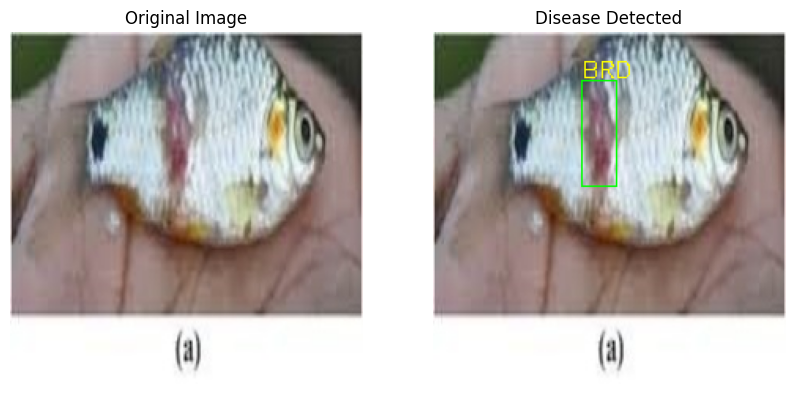

In [11]:
disease_detector(selected_img)